In [242]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

In [280]:
# Specify the sample
ticker = 'NVDA'
start = '2020-01-01'
end = '2024-09-27'

# Downloading data
prices = yf.download(ticker, start, end)['Close']

# Check if prices are empty
if prices.empty:
    raise ValueError("No data fetched. Please check the ticker symbol and date range.")

# Calculate the natural log of price ratios (log returns)
log_returns = np.log(prices[1:] / prices[:-1])

[*********************100%%**********************]  1 of 1 completed


In [281]:
# Calculate realized volatility (annualized) using thinkorswim method
def calculate_thinkorswim_volatility(prices, window=20):
    returns = prices.pct_change().dropna()
    log_returns = np.log(1 + returns)
    
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252) * 100
    return volatility

In [282]:
# Calculate realized volatility using thinkorswim method
realized_volatility = calculate_thinkorswim_volatility(prices)

# Align the indices of realized volatility with the prices
realized_volatility = realized_volatility.dropna()

# Calculate returns for GARCH model
returns = np.array(prices)[1:] / np.array(prices)[:-1] - 1

In [283]:
# GARCH log-likelihood function with p and q parameters
def garch_mle(params, p, q):
    # Specifying model parameters
    mu = params[0]
    omega = params[1]
    alphas = params[2:2+p]
    betas = params[2+p:2+p+q]
    
    # Calculating long-run volatility
    long_run = (omega / (1 - np.sum(alphas) - np.sum(betas)))**(1/2)
    
    # Calculating conditional volatility
    resid = returns - mu
    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    for t in range(1, len(returns)):
        conditional[t] = np.sqrt(omega + 
                                 np.sum([alphas[i] * resid[t-i-1]**2 for i in range(min(p, t))]) + 
                                 np.sum([betas[j] * conditional[t-j-1]**2 for j in range(min(q, t))]))
    
    # Calculating log-likelihood
    likelihood = 1 / ((2 * np.pi)**(1/2) * conditional) * np.exp(-resid**2 / (2 * conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

In [284]:
# Function to select the best p and q
def select_best_pq(max_p=3, max_q=3):
    best_params = None
    best_log_likelihood = np.inf
    best_p, best_q = 0, 0
    
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            # Starting parameter values - sample mean and variance
            initial_params = np.array([np.mean(returns), np.var(returns)] + [0.1]*p + [0.1]*q)
            
            # Minimizing the negative log-likelihood
            res = spop.minimize(garch_mle, initial_params, args=(p, q), method='Nelder-Mead')
            
            # Check if the log-likelihood is better
            if res.fun < best_log_likelihood:
                best_log_likelihood = res.fun
                best_params = res.x
                best_p, best_q = p, q
                
    return best_p, best_q, best_params, best_log_likelihood

# Select the best p and q
best_p, best_q, best_params, best_log_likelihood = select_best_pq(max_p=3, max_q=3)

/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_79124/2290471850.py:10: RuntimeWarning: invalid value encountered in scalar power
  long_run = (omega / (1 - np.sum(alphas) - np.sum(betas)))**(1/2)
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_79124/2290471850.py:17: RuntimeWarning: invalid value encountered in sqrt
  conditional[t] = np.sqrt(omega +
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_79124/2290471850.py:22: RuntimeWarning: divide by zero encountered in divide
  likelihood = 1 / ((2 * np.pi)**(1/2) * conditional) * np.exp(-resid**2 / (2 * conditional**2))
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_79124/2290471850.py:22: RuntimeWarning: invalid value encountered in multiply
  likelihood = 1 / ((2 * np.pi)**(1/2) * conditional) * np.exp(-resid**2 / (2 * conditional**2))


In [285]:
# Extract parameters from the best model
mu = best_params[0]
omega = best_params[1]
alphas = best_params[2:2+best_p]
betas = best_params[2+best_p:2+best_p+best_q]
long_run = (omega / (1 - np.sum(alphas) - np.sum(betas)))**(1/2)

# Calculate conditional volatility with the best p and q
resid = returns - mu
conditional_volatility = np.zeros(len(returns))
conditional_volatility[0] = long_run
for t in range(1, len(returns)):
    conditional_volatility[t] = np.sqrt(omega + 
                                        np.sum([alphas[i] * resid[t-i-1]**2 for i in range(min(best_p, t))]) + 
                                        np.sum([betas[j] * conditional_volatility[t-j-1]**2 for j in range(min(best_q, t))]))
    
# Annualize the conditional volatility
conditional_volatility_annualized = conditional_volatility * np.sqrt(252) * 100

# Calculate mean and standard deviations for the plot
mean_volatility = np.mean(conditional_volatility_annualized)
std_volatility = np.std(conditional_volatility_annualized)

In [286]:
# Print the selected p, q, and parameters
print(f'Best p: {best_p}, Best q: {best_q}')
print(f'mu: {mu:.6f}')
print(f'omega: {omega:.6f}')
print(f'alpha coefficients: {alphas}')
print(f'beta coefficients: {betas}')
print(f'long-run volatility: {long_run:.4f}')
print(f'log-likelihood: {-best_log_likelihood:.4f}')

Best p: 2, Best q: 3
mu: 0.004148
omega: 0.000192
alpha coefficients: [0.0735157  0.17158161]
beta coefficients: [-0.06204939  0.21041602  0.45505289]
long-run volatility: 0.0356
log-likelihood: 2332.7338


<Figure size 640x480 with 0 Axes>

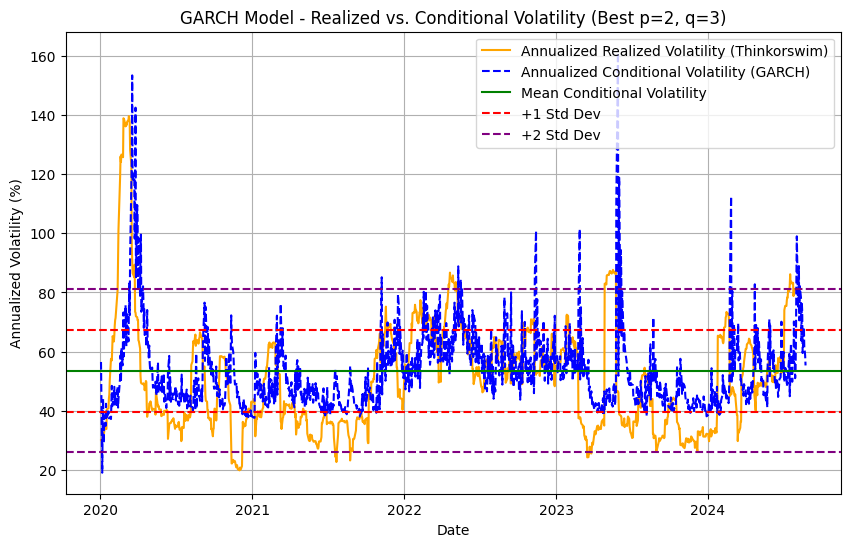

In [287]:
# Visualizing the results
plt.figure(1)
plt.rc('xtick', labelsize=10)
plt.figure(figsize=(10, 6))

# Plot realized volatility (calculated using Thinkorswim's method)
plt.plot(prices.index[1:len(realized_volatility) + 1], realized_volatility, label='Annualized Realized Volatility (Thinkorswim)', color='orange')

# Plot annualized conditional volatility
plt.plot(prices.index[1:], conditional_volatility_annualized, label='Annualized Conditional Volatility (GARCH)', linestyle='--', color='blue')

# Plot the mean volatility
plt.axhline(mean_volatility, color='green', linestyle='-', label='Mean Conditional Volatility')

# Plot +1 and +2 standard deviations
plt.axhline(mean_volatility + std_volatility, color='red', linestyle='--', label='+1 Std Dev')
plt.axhline(mean_volatility + 2*std_volatility, color='purple', linestyle='--', label='+2 Std Dev')

# Plot -1 and -2 standard deviations
plt.axhline(mean_volatility - std_volatility, color='red', linestyle='--')
plt.axhline(mean_volatility - 2*std_volatility, color='purple', linestyle='--')

# Add legend
plt.legend()

# Add title and labels
plt.title(f'GARCH Model - Realized vs. Conditional Volatility (Best p={best_p}, q={best_q})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()

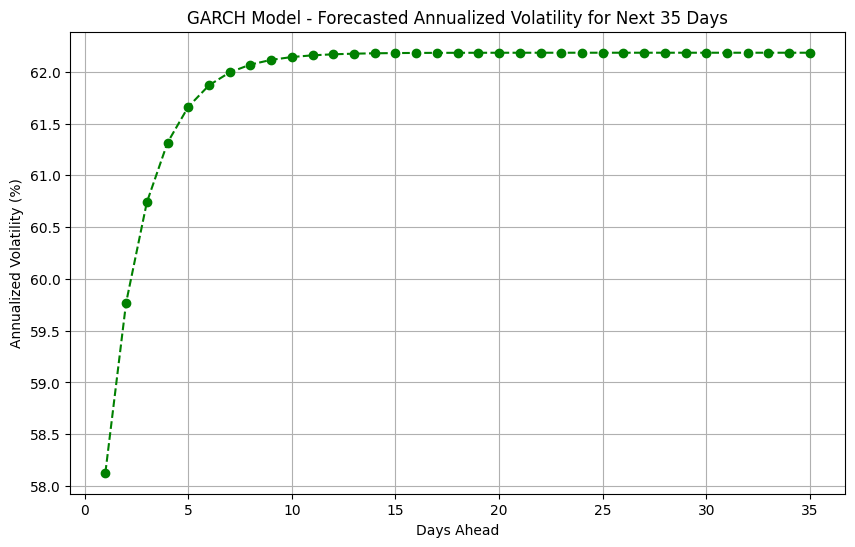

In [288]:
# Forecasting Volatility for the next 35 days
forecast_horizon = 35

# Initialize the forecasted conditional volatility array
forecasted_volatility = np.zeros(forecast_horizon)

# The last conditional volatility value from the fitted model
last_volatility = conditional_volatility[-1]

# Forecast future volatilities based on the best model parameters
for t in range(forecast_horizon):
    forecasted_volatility[t] = np.sqrt(omega + 
                                       np.sum([alphas[i] * resid[-i-1]**2 for i in range(best_p)]) + 
                                       np.sum([betas[j] * last_volatility**2 for j in range(best_q)]))
    last_volatility = forecasted_volatility[t]  # Update the last volatility for the next iteration

# Annualize the forecasted volatilities
forecasted_volatility_annualized = forecasted_volatility * np.sqrt(252) * 100

# Visualizing the forecasted volatility for the next 35 days
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), forecasted_volatility_annualized, marker='o', linestyle='--', color='green')
plt.title(f'GARCH Model - Forecasted Annualized Volatility for Next {forecast_horizon} Days')
plt.xlabel('Days Ahead')
plt.ylabel('Annualized Volatility (%)')
plt.grid(True)
plt.show()


# Complete Implementation

[*********************100%%**********************]  1 of 1 completed
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_79124/144953678.py:48: RuntimeWarning: invalid value encountered in scalar power
  long_run = (omega / (1 - np.sum(alphas) - np.sum(betas)))**(1/2)
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_79124/144953678.py:55: RuntimeWarning: invalid value encountered in sqrt
  conditional[t] = np.sqrt(omega +


Best p: 2, Best q: 2
mu: 0.003479
omega: 0.000117
alpha coefficients: [0.06170429 0.18414633]
beta coefficients: [0.04603273 0.61560181]
long-run volatility: 0.0356
log-likelihood: 3447.0633


<Figure size 640x480 with 0 Axes>

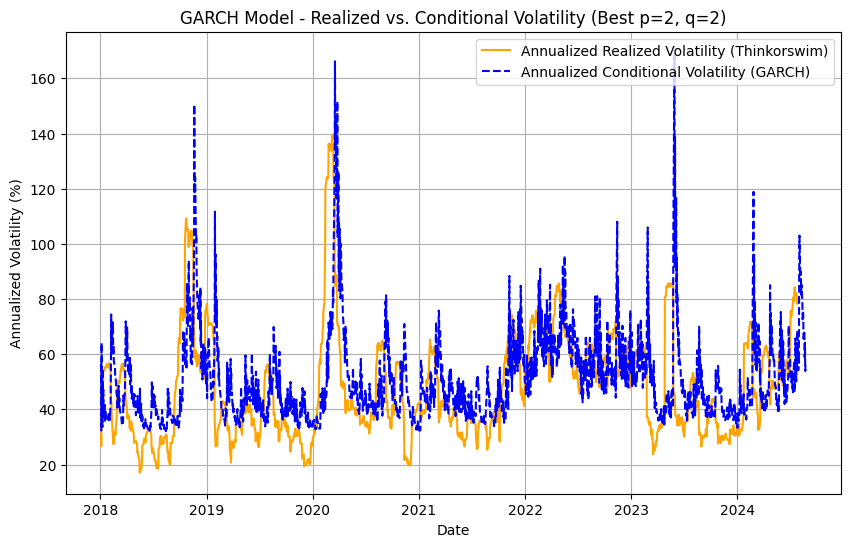

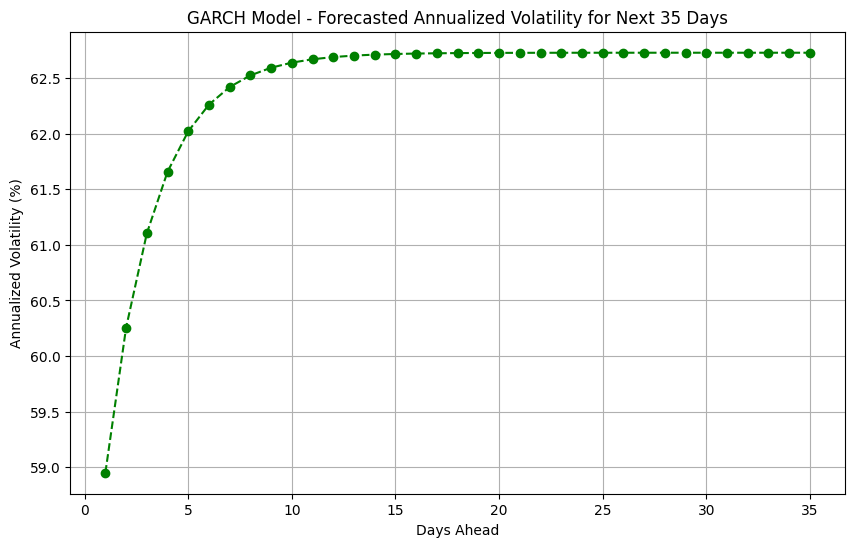

In [279]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

# Specify the sample
ticker = 'NVDA'
start = '2018-01-01'
end = '2024-09-27'

# Downloading data
prices = yf.download(ticker, start, end)['Close']

# Check if prices are empty
if prices.empty:
    raise ValueError("No data fetched. Please check the ticker symbol and date range.")

# Calculate the natural log of price ratios (log returns)
log_returns = np.log(prices[1:] / prices[:-1])

# Calculate realized volatility (annualized) using thinkorswim method
def calculate_thinkorswim_volatility(prices, window=21):
    returns = prices.pct_change().dropna()
    log_returns = np.log(1 + returns)
    
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252) * 100
    return volatility

# Calculate realized volatility using thinkorswim method
realized_volatility = calculate_thinkorswim_volatility(prices)

# Align the indices of realized volatility with the prices
realized_volatility = realized_volatility.dropna()

# Calculate returns for GARCH model
returns = np.array(prices)[1:] / np.array(prices)[:-1] - 1

# GARCH log-likelihood function with p and q parameters
def garch_mle(params, p, q):
    # Specifying model parameters
    mu = params[0]
    omega = params[1]
    alphas = params[2:2+p]
    betas = params[2+p:2+p+q]
    
    # Calculating long-run volatility
    long_run = (omega / (1 - np.sum(alphas) - np.sum(betas)))**(1/2)
    
    # Calculating conditional volatility
    resid = returns - mu
    conditional = np.zeros(len(returns))
    conditional[0] = long_run
    for t in range(1, len(returns)):
        conditional[t] = np.sqrt(omega + 
                                 np.sum([alphas[i] * resid[t-i-1]**2 for i in range(min(p, t))]) + 
                                 np.sum([betas[j] * conditional[t-j-1]**2 for j in range(min(q, t))]))
    
    # Calculating log-likelihood
    likelihood = 1 / ((2 * np.pi)**(1/2) * conditional) * np.exp(-resid**2 / (2 * conditional**2))
    log_likelihood = np.sum(np.log(likelihood))
    return -log_likelihood

# Function to select the best p and q
def select_best_pq(max_p=3, max_q=3):
    best_params = None
    best_log_likelihood = np.inf
    best_p, best_q = 0, 0
    
    for p in range(1, max_p + 1):
        for q in range(1, max_q + 1):
            # Starting parameter values - sample mean and variance
            initial_params = np.array([np.mean(returns), np.var(returns)] + [0.1]*p + [0.1]*q)
            
            # Minimizing the negative log-likelihood
            res = spop.minimize(garch_mle, initial_params, args=(p, q), method='Nelder-Mead')
            
            # Check if the log-likelihood is better
            if res.fun < best_log_likelihood:
                best_log_likelihood = res.fun
                best_params = res.x
                best_p, best_q = p, q
                
    return best_p, best_q, best_params, best_log_likelihood

# Select the best p and q
best_p, best_q, best_params, best_log_likelihood = select_best_pq(max_p=3, max_q=3)

# Extract parameters from the best model
mu = best_params[0]
omega = best_params[1]
alphas = best_params[2:2+best_p]
betas = best_params[2+best_p:2+best_p+best_q]
long_run = (omega / (1 - np.sum(alphas) - np.sum(betas)))**(1/2)

# Calculate conditional volatility with the best p and q
resid = returns - mu
conditional_volatility = np.zeros(len(returns))
conditional_volatility[0] = long_run
for t in range(1, len(returns)):
    conditional_volatility[t] = np.sqrt(omega + 
                                        np.sum([alphas[i] * resid[t-i-1]**2 for i in range(min(best_p, t))]) + 
                                        np.sum([betas[j] * conditional_volatility[t-j-1]**2 for j in range(min(best_q, t))]))

# Annualize the conditional volatility
conditional_volatility_annualized = conditional_volatility * np.sqrt(252) * 100

# Print the selected p, q, and parameters
print(f'Best p: {best_p}, Best q: {best_q}')
print(f'mu: {mu:.6f}')
print(f'omega: {omega:.6f}')
print(f'alpha coefficients: {alphas}')
print(f'beta coefficients: {betas}')
print(f'long-run volatility: {long_run:.4f}')
print(f'log-likelihood: {-best_log_likelihood:.4f}')

# Visualizing the results
plt.figure(1)
plt.rc('xtick', labelsize=10)
plt.figure(figsize=(10, 6))

# Plot realized volatility (calculated using Thinkorswim's method)
plt.plot(prices.index[1:len(realized_volatility) + 1], realized_volatility, label='Annualized Realized Volatility (Thinkorswim)', color='orange')

# Plot annualized conditional volatility
plt.plot(prices.index[1:], conditional_volatility_annualized, label='Annualized Conditional Volatility (GARCH)', linestyle='--', color='blue')

# Add legend
plt.legend()

# Add title and labels
plt.title(f'GARCH Model - Realized vs. Conditional Volatility (Best p={best_p}, q={best_q})')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()


# Forecasting Volatility for the next 35 days
forecast_horizon = 35

# Initialize the forecasted conditional volatility array
forecasted_volatility = np.zeros(forecast_horizon)

# The last conditional volatility value from the fitted model
last_volatility = conditional_volatility[-1]

# Forecast future volatilities based on the best model parameters
for t in range(forecast_horizon):
    forecasted_volatility[t] = np.sqrt(omega + 
                                       np.sum([alphas[i] * resid[-i-1]**2 for i in range(best_p)]) + 
                                       np.sum([betas[j] * last_volatility**2 for j in range(best_q)]))
    last_volatility = forecasted_volatility[t]  # Update the last volatility for the next iteration

# Annualize the forecasted volatilities
forecasted_volatility_annualized = forecasted_volatility * np.sqrt(252) * 100

# Visualizing the forecasted volatility for the next 35 days
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), forecasted_volatility_annualized, marker='o', linestyle='--', color='green')
plt.title(f'GARCH Model - Forecasted Annualized Volatility for Next {forecast_horizon} Days')
plt.xlabel('Days Ahead')
plt.ylabel('Annualized Volatility (%)')
plt.grid(True)
plt.show()

